# Chapter 8. Inferene Engines

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap, lax, tree_map, hessian
from jax import nn as jnn
from jax.scipy import stats, special

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

## Non-Markovian methods

### Grid computing


In [4]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = jnp.linspace(0.01, 1, grid_points)
    prior = jnp.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = jnp.exp(dist.Binomial(total_count=(heads+tails), probs=grid).log_prob(heads))
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

Assuming we flip a coin 13 times and we observed 3 head we have:

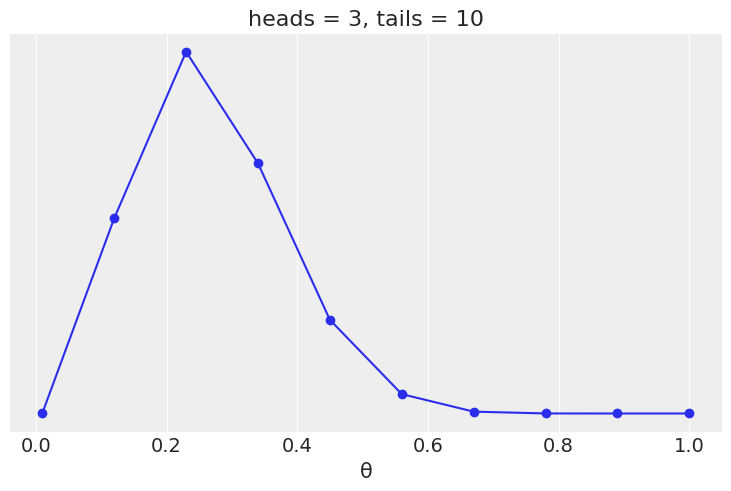

In [5]:
data = jnp.repeat(jnp.array([0, 1]), jnp.asarray((10, 3)))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

### Quadratic method

In [6]:
def model(obs=None):
    p = numpyro.sample('p', dist.Beta(concentration1=1., concentration0=1.))
    w = numpyro.sample('w', dist.Binomial(total_count=1, probs=p), obs=obs)
                       
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), obs=data)
svi_result = svi.run(random.PRNGKey(0), 20000)
params = svi_result.params
params

100%|████████████████████| 20000/20000 [00:01<00:00, 11830.65it/s, init loss: 11.2695, avg. loss [19001-20000]: 8.6997]


{'auto_loc': DeviceArray([-1.0116092], dtype=float32)}

In [7]:
samples = guide.sample_posterior(random.PRNGKey(0), params, (10000,))

In [8]:
xs = jnp.sort(samples['p'])
std_q = jnp.std(xs)
mean_q = jnp.mean(xs)
mean_q, std_q 

(DeviceArray(0.28205067, dtype=float32),
 DeviceArray(0.11372714, dtype=float32))

([], [])

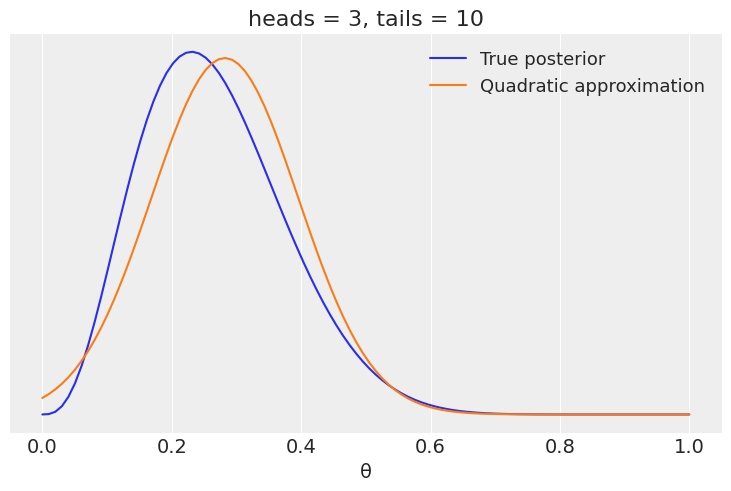

In [9]:
# analytical calculation
x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(dist.Beta(h+1, t+1).log_prob(x)), label='True posterior')

# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(mean_q, std_q).log_prob(x)),label='Quadratic approximation')
# plt.plot(x, guide.(params).sample(random.PRNGKey(0), sample_shape=(len(x),)))
plt.legend(loc=0, fontsize=13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])

In [10]:
quantiles = guide.quantiles(params, 0.5)
quantiles

{'p': DeviceArray(0.26666504, dtype=float32)}

In [11]:
guide.median(params)

{'p': DeviceArray(0.26666504, dtype=float32)}

In [12]:
# predictive = Predictive(guide, params=params, num_samples=1000)
# samples = predictive(random.PRNGKey(1), data)

In [13]:
numpyro.diagnostics.hpdi(samples['p'], prob=0.5)

array([0.17510453, 0.32284716], dtype=float32)

In [14]:
# with pm.Model() as normal_aproximation:
#     p = pm.Beta('p', 1., 1.)
#     w = pm.Binomial('w',n=1, p=p, observed=data)
#     mean_q = pm.find_MAP()
#     std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
# mean_q['p'], std_q

## Markovian methods

### Monte Carlo


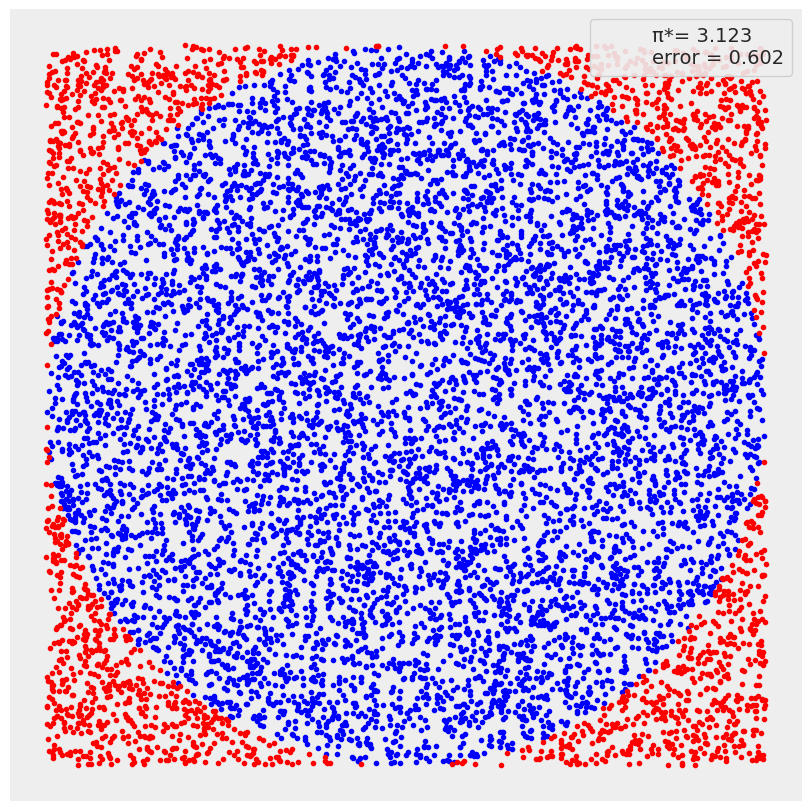

In [15]:
N = 10000

x, y = dist.Uniform(low=-1, high=1).sample(random.PRNGKey(0), sample_shape=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - jnp.pi) / pi) * 100
 
outside = jnp.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9)

In [17]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = jnp.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = jnp.exp(func.log_prob(old_x))

    delta = dist.Normal(loc=0, scale=0.5).sample(random.PRNGKey(0), sample_shape=(draws,))
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = jnp.exp(func.log_prob(new_x))
        acceptance = new_prob / old_prob
#         if acceptance >= dist.Uniform(low=0, high=1).sample(random.PRNGKey(i)):
        if acceptance >= random.uniform(random.PRNGKey(i)):
            trace = trace.at[i].set(new_x)
            old_x = new_x
            old_prob = new_prob
        else:
            # x[idx] = y``, use ``x = x.at[idx].set(y)
            trace = trace.at[i].set(old_x)

    return trace

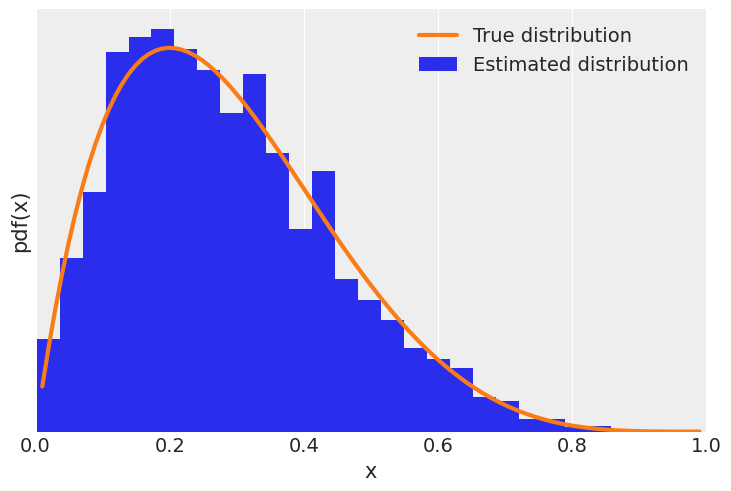

In [18]:
func = dist.Beta(concentration1=2, concentration0=5)

trace = metropolis(func=func) 
x = jnp.linspace(0.01, .99, 100) 
y = jnp.exp(func.log_prob(x)) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()

## Diagnosing the samples

In [19]:
def centered_model(obs=None):
    a = numpyro.sample('a', dist.HalfNormal(scale=10))
    b = numpyro.sample('b', dist.Normal(loc=0, scale=a), sample_shape=(10,))
    
kernel = NUTS(centered_model, target_accept_prob=0.85)
trace_cm = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2, chain_method='sequential')
trace_cm.run(random.PRNGKey(seed))

def non_centered_model(obs=None):
    a = numpyro.sample('a', dist.HalfNormal(scale=10))
    b_offset = numpyro.sample('b_offset', dist.Normal(loc=0, scale=1), sample_shape=(10,))
    b = numpyro.deterministic('b', 0 + b_offset * a)
    
kernel = NUTS(non_centered_model, target_accept_prob=0.85)
trace_ncm = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2, chain_method='sequential')
trace_ncm.run(random.PRNGKey(seed))

sample: 100%|██████████████████████████| 2000/2000 [00:00<00:00, 7252.10it/s, 7 steps of size 5.03e-01. acc. prob=0.89]


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

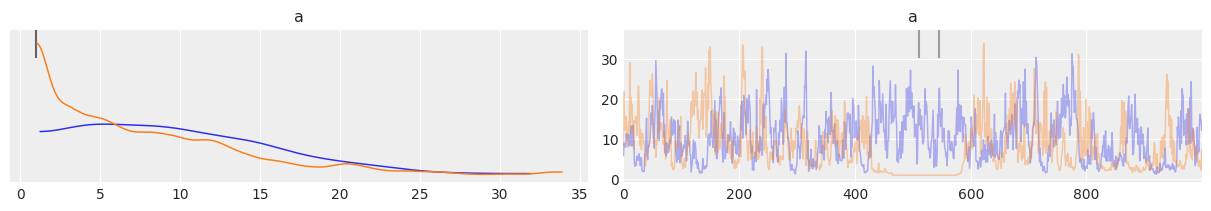

In [20]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top', compact=False)

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

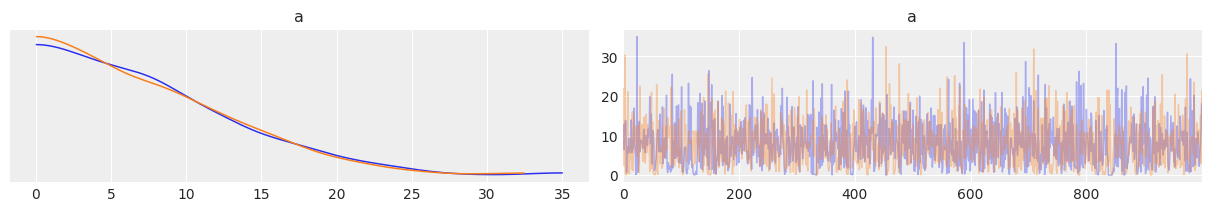

In [21]:
az.plot_trace(trace_ncm, var_names=['a'], compact=False)

In [22]:
az.summary(trace_cm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.190,6.295,1.013,20.570,0.749,0.532,41.0,22.0,1.05
b[0],0.052,11.401,-24.873,20.704,0.226,0.359,2342.0,771.0,1.02
b[1],0.247,10.922,-23.837,21.836,0.214,0.365,2497.0,936.0,1.02
b[2],0.039,10.862,-21.110,21.709,0.216,0.362,2675.0,928.0,1.03
b[3],-0.065,11.525,-22.748,23.628,0.215,0.402,2880.0,998.0,1.02
b[4],0.045,11.595,-23.655,22.588,0.221,0.356,3088.0,825.0,1.02
b[5],0.340,10.935,-19.502,22.569,0.217,0.399,2521.0,802.0,1.02
b[6],0.217,12.287,-26.847,23.079,0.251,0.432,2750.0,715.0,1.03
b[7],0.366,11.802,-26.457,21.237,0.219,0.366,2806.0,996.0,1.03
b[8],0.381,11.643,-20.940,24.580,0.226,0.338,2814.0,988.0,1.05


In [23]:
az.rhat(trace_cm)['a'].values, az.rhat(trace_ncm)['a'].values

(array(1.04987792), array(1.00006256))

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

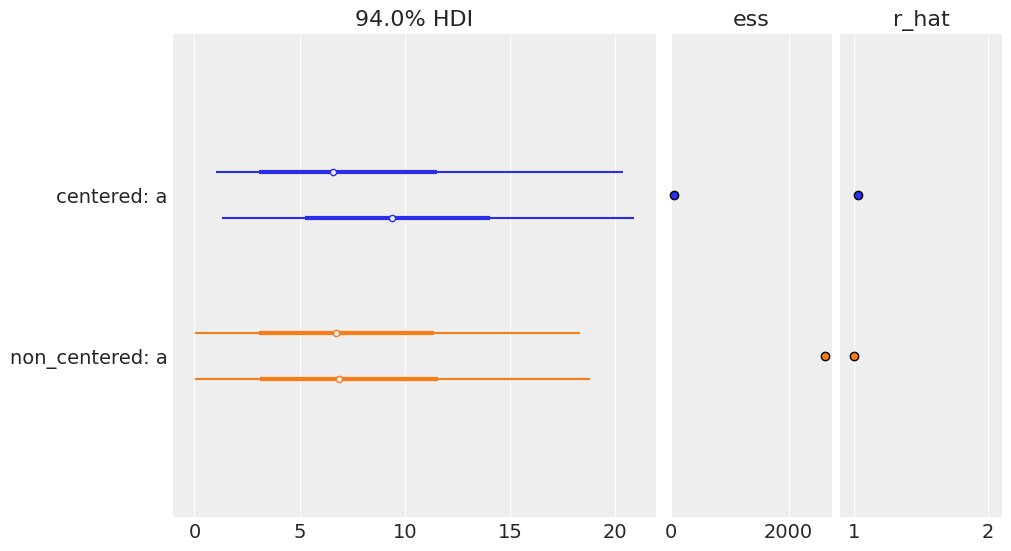

In [24]:
az.plot_forest([trace_cm, trace_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True, ess=True)

In [25]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
           az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,9.190,6.295,1.013,20.570,0.749,0.532,41.0,22.0,1.05
non_centered,7.896,6.012,0.007,18.599,0.117,0.083,1567.0,727.0,1.00


array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>], dtype=object)

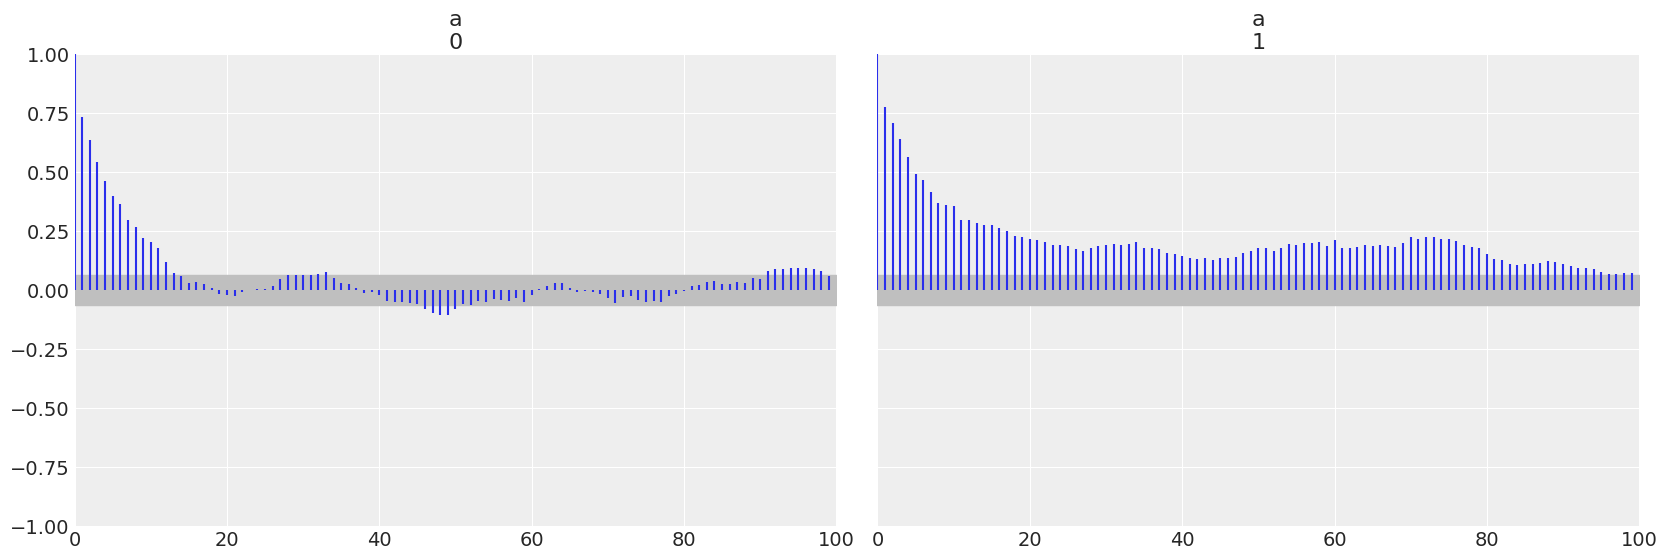

In [26]:
az.plot_autocorr(trace_cm, var_names=['a'])

array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>], dtype=object)

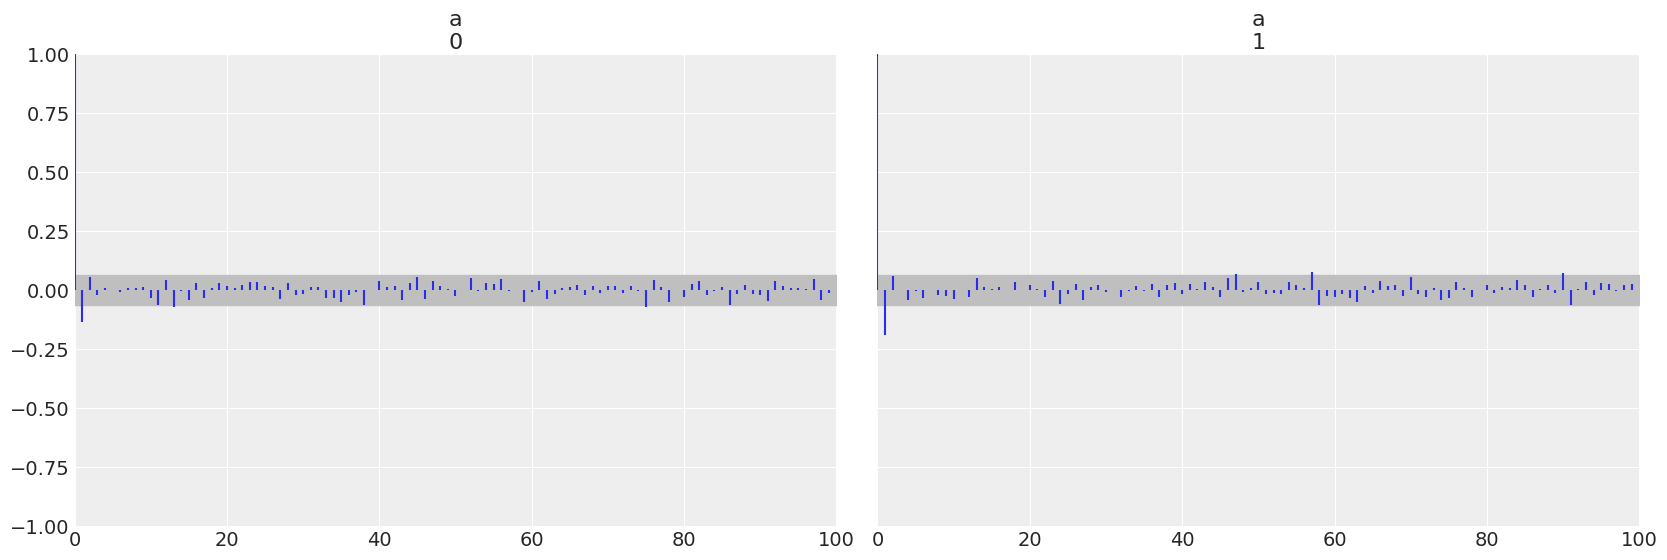

In [27]:
az.plot_autocorr(trace_ncm, var_names=['a'])

## Effective sample size

In [28]:
az.ess(trace_cm)['a'].values

array(41.46579247)

## Divergences

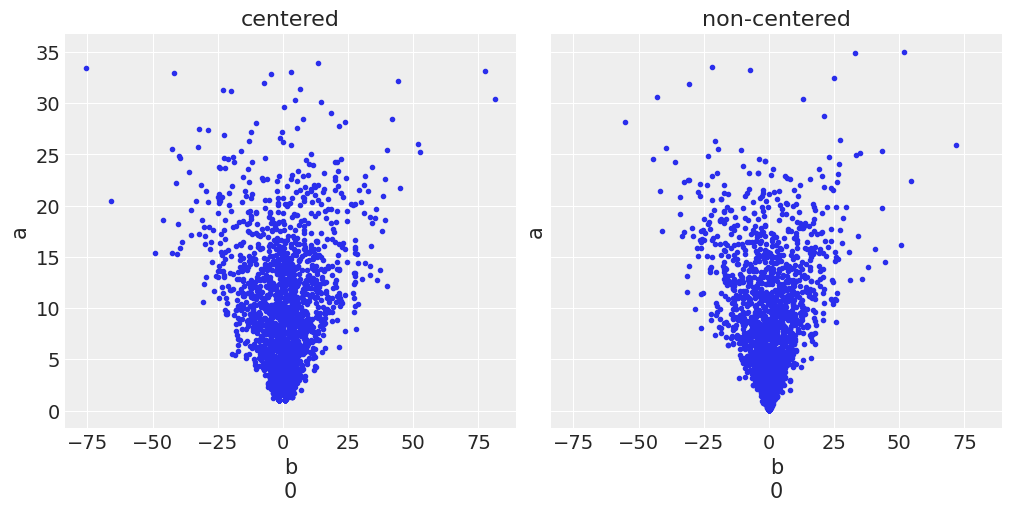

In [29]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

<AxesSubplot:>

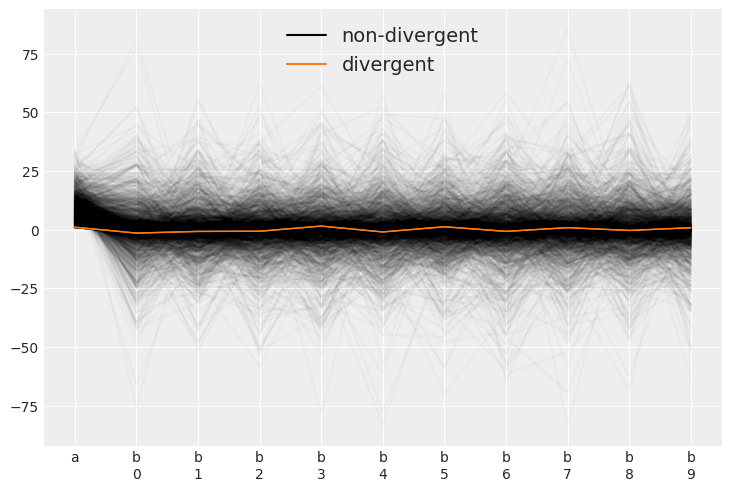

In [30]:
az.plot_parallel(trace_cm)